In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

matplotlib.rcParams.update({'font.size': 14})
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
outpath = ""

In [3]:
gene = "MYL6"
donor_pos = [56160320,56160670]
acceptor_pos = [56160626,56161387]

In [4]:
# create a color dictionary for tissues
def tissue_colors():
    
    tissue_color_dict = {'Bladder': '#e7969c',
             'Blood': '#d6616b',
             'Bone_Marrow': '#cedb9c',
             'Eye': '#c7ea46',#"#00ff7f",
             'Fat': '#e7cb94',
             'Heart': '#ff0800',
             'Kidney': '#7b4173',
             'Large_Intestine': '#31a354',
             'Liver': '#000080',
             'Lung': '#3182bd',
             'Lymph_Node': '#8c6d31',
             'Mammary':'#ce6dbd',
             'Muscle': '#e7ba52',
             'Pancreas': '#fd8d3c',
             'Prostate':'#637939',#'#a55194',#
             'Salivary_Gland':'#622a0f',
             'Skin': '#de9ed6',
             'Small_Intestine': '#6baed6',
             'Spleen': '#393b79',
             'Thymus': '#9c9ede',
             'Tongue':'#b5cf6b',
             'Trachea': '#969696',
             'Uterus':'#c64b8c',#'#ff0090',
             'Vasculature': '#843c39'}
    
    return tissue_color_dict

In [5]:
in_path = ""
datanames = ["TSP1_10x_with_postprocessing_newann_MYL6","TSP2_10x_rerun_with_postprocessing_newann_MYL6","TSP14_10x_Muscle_Lung_Blood_Bladder_newann_MYL6"]
dfs = []
cell_lim = 10
read_lim = 10

for dataname in tqdm(datanames):
  
  df = pd.read_parquet("{}{}.pq".format(in_path, dataname))
 
  df = df[~df["compartment"].isna()]
  # subset to only junctions contributing to exon skipping event
  df = df[df["geneR1A_uniq"] == gene]
  df = df[df["juncPosR1A"].isin(donor_pos) & (df["juncPosR1B"].isin(acceptor_pos))]
  df["total_numReads"] = df["cell"].map(df.groupby("cell")["numReads"].sum())
  df = df[df["total_numReads"] > read_lim]
  
  # Find those corresponding to exon inclusion
  df["exon_inc"] = True
  df.loc[(df["juncPosR1A"] == donor_pos[0]) & (df["juncPosR1B"] == acceptor_pos[1]),"exon_inc"] = False
  sub = df[df["exon_inc"]]
  df["inc_numReads"] = df["cell"].map(sub.groupby("cell")["numReads"].sum())
  
  # calculate frac included for each cell
  df["frac_inc"] = df["inc_numReads"] / df["total_numReads"]
#   df["ontology"] = df["tissue"] + df["compartment"] + df["free_annotation"]
  df["ontology"] = df["tissue"] + df["compartment"] + df["cell_ontology_class"]
  df["num_cells_ont"] = df["ontology"].map(df.groupby("ontology")["cell"].nunique())
  df = df[df["num_cells_ont"] > cell_lim]
  df = df.drop_duplicates("cell")
  dfs.append(df)

100%|██████████| 3/3 [00:00<00:00,  3.07it/s]


In [6]:
shared_onts = set(dfs[0]["ontology"].unique()).intersection(set(dfs[1]["ontology"].unique())).intersection(set(dfs[2]["ontology"].unique()))
subdfs = []
for i in range(len(dfs)):
  dfs[i]["ont_mean"] = dfs[i].groupby("ontology")["frac_inc"].transform("mean")
  subdfs.append(dfs[i].drop_duplicates("ontology")[["ontology","ont_mean"]])
sub = subdfs[0].merge(subdfs[1],on="ontology").merge(subdfs[2],on="ontology")
sub["mean"] = sub[["ont_mean_x","ont_mean_y","ont_mean"]].mean(axis=1)
sub = sub.sort_values("mean")
order_ontologies = sub["ontology"]
order = {ont : val for ont, val in zip(order_ontologies, range(len(order_ontologies)))}
for i in range(len(dfs)):
  dfs[i] = dfs[i][dfs[i]["ontology"].isin(shared_onts)]
  dfs[i]["ontology2"] = dfs[i]["compartment"] + dfs[i]["tissue"] + dfs[i]["cell_ontology_class"]
  dfs[i]["order"] = dfs[i]["ontology"].map(order)
  dfs[i] = dfs[i].sort_values(["compartment","order"])
mapping = dfs[0].drop_duplicates("ontology")[["ontology","cell_ontology_class"]]
map_onts = dict(zip(mapping.ontology, mapping.cell_ontology_class))

yticks = list(dfs[i].drop_duplicates("ontology")["cell_ontology_class"])#order_ontologies#list(dfs[0].drop_duplicates("ontology2")[["ontology2","cell_ontology_class"]].sort_values("ontology2")["cell_ontology_class"])

# palette = compartment_colors()
palette = tissue_colors()

y_vals = []
prev = "Endothelial"
for k, v in zip(range(1,len(shared_onts)),sorted(dfs[0]["ontology2"].unique())):
  if not v.startswith(prev):
#     print("here",k,v,v.startswith(prev))
    prev = v[:5]
    y_vals.append(k - 1.5)

/home/users/jolivier/.local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


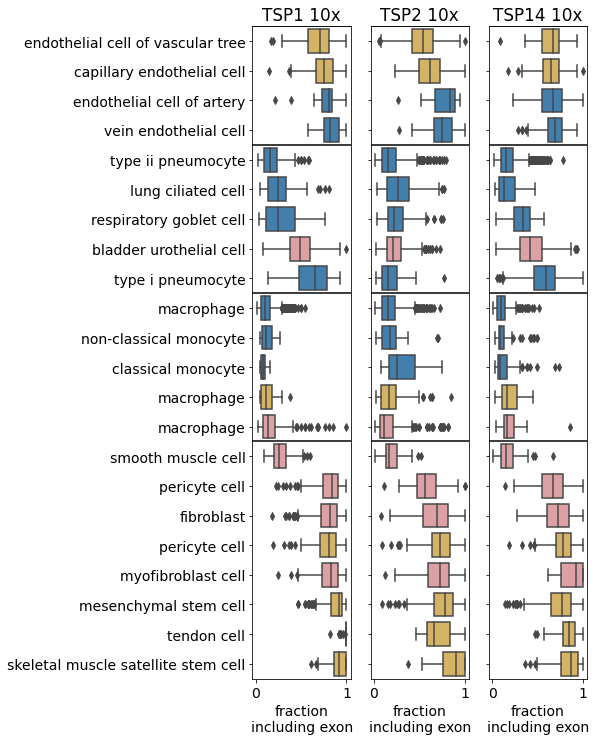

In [8]:
palette = tissue_colors()
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(6,12))

g1 = sns.boxplot(x="frac_inc",y="ontology",hue="tissue",dodge=False,data=dfs[0],orient="h",palette = palette,ax=ax1)

g2 = sns.boxplot(x="frac_inc",y="ontology",hue="tissue",dodge=False,data=dfs[1],orient="h",palette = palette,ax=ax2)
g3 = sns.boxplot(x="frac_inc",y="ontology",hue="tissue",dodge=False,data=dfs[2],orient="h",palette = palette,ax=ax3)

g1.legend_.remove()
g2.legend_.remove()
g3.legend_.remove()
g1.set_title("TSP1 10x")
g2.set_title("TSP2 10x")
g3.set_title("TSP14 10x")
g1.axes.set_ylabel("")
g2.axes.set_ylabel("")
g3.axes.set_ylabel("")


g1.axes.set_xlabel("fraction\nincluding exon")
g2.axes.set_xlabel("fraction\nincluding exon")
g3.axes.set_xlabel("fraction\nincluding exon")
g2.set(yticklabels=[])
g3.set(yticklabels=[])
g1.set(yticklabels=yticks)

for y in y_vals:
  ax1.axhline(y=y,color="black")
  ax2.axhline(y=y,color="black")
  ax3.axhline(y=y,color="black")

plt.savefig("{}{}_colored_by_tissue_box_{}_{}.png".format(outpath,gene,cell_lim,read_lim),bbox_inches="tight")
plt.savefig("{}{}_colored_by_tissue_box_{}_{}.pdf".format(outpath,gene,cell_lim,read_lim),format="pdf",bbox_inches="tight")

plt.show()